In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install rasterio

In [3]:
import os
import numpy as np
import rasterio as rio
from numba import jit
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [4]:
# Define function to load the data
def load_data(filepath):
    folder_lst = []
    for folder in os.listdir(filepath):
        tif_lst = []
        for tif in os.listdir(filepath + folder):
            # Read the tif as a numpy array
            frame = rio.open(filepath + folder + '/' + tif).read(1).astype('int')

            # Add time dimension
            frame = np.expand_dims(frame, axis=0)
            # Add sample dimension
            frame = np.expand_dims(frame, axis=0)

            tif_lst.append(frame)
        # Concatenate across samples
        folder_lst.append(np.concatenate(tif_lst, axis=0))

    # Concatenate across time
    dataset = np.concatenate(folder_lst, axis=1)
    return dataset

In [5]:
# Define function to preprocess the data
@jit(nopython=True)
def preprocess(raw_dataset):
    # Convert all values to one of three categories: 
    # 0 for missing data, 1 for no deforestation, and 2 for deforestation
    cat_dataset = np.digitize(raw_dataset, bins=[-0.5, 0.5])

    # One-hot encode the data
    # This expands the number of channels for each raster from one to three
    # The first channel is equal to 1 if data is missing, 0 otherwise
    # The second channel is equal to 1 if no deforestation occurred, 0 otherwise
    # The third channel is equal to 1 if deforestation occurred, 0 otherwise
    dataset = (np.arange(cat_dataset.max()+1) == np.expand_dims(cat_dataset, axis=-1)).astype(np.int64)

    return dataset    

In [6]:
# Load the data
dataset = load_data('/content/gdrive/MyDrive/data/') # replace this function with Keras's data loader
dataset = preprocess(dataset)

In [7]:
# Get the size of the dataset
print('Dataset size:', dataset.shape)

num_samples = dataset.shape[0]
print('Number of rasters per year:', num_samples)

num_frames = dataset.shape[1]
print('Number of years:', num_frames)

raster_size = dataset.shape[2:]
print('Raster size:', raster_size)

Dataset size: (10, 18, 40, 40, 3)
Number of rasters per year: 10
Number of years: 18
Raster size: (40, 40, 3)


In [ ]:
# Split into train and test sets (use indexing to optimize memory)
train_prop = 0.8
sample_indices = np.arange(dataset.shape[0])
np.random.seed(123)
np.random.shuffle(sample_indices)
train_indices = sample_indices[:int(train_prop * dataset.shape[0])]
test_indices = sample_indices[int(train_prop * dataset.shape[0]):]
train_dataset = dataset[train_indices]
test_dataset = dataset[test_indices]

In [ ]:
# Define function to extract features and outcome variable
# x is frames 0 to n-1, and y is frames 1 to n
def split_x_y(data):
    x = data[:, 0:data.shape[1]-1, :, :]
    y = data[:, 1:data.shape[1], :, :]
    return x, y

In [ ]:
# Extract features and outcome variable
x_train, y_train = split_x_y(train_dataset)
x_test, y_test = split_x_y(test_dataset)

In [ ]:
# Get the size of the training and test sets
print("Training Feature Shape: " + str(x_train.shape) + 
      ", Training Outcome Shape: " + str(y_train.shape))
print("Testing Feature Shape: " + str(x_test.shape) + 
      ", Testing Outcome Shape: " + str(y_test.shape))

Training Feature Shape: (8, 17, 40, 40, 3), Training Outcome Shape: (8, 17, 40, 40, 3)
Testing Feature Shape: (2, 17, 40, 40, 3), Testing Outcome Shape: (2, 17, 40, 40, 3)


In [ ]:
# Define hyperparameters (we can cross-validate these later)
epochs = 50
batch_size = 8
num_filters = 64

In [ ]:
# Define the CNN-LSTM architecture

# Construct the input layer with no definite frame size
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# Construct three ConvLSTM2D layers with batch norm,
# followed by a Conv3D layer so that the output is
# the same shape as the original raster
x = layers.ConvLSTM2D(filters=num_filters,
                      kernel_size=(5, 5),
                      padding="same",
                      return_sequences=True,
                      activation="relu",)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(filters=num_filters,
                      kernel_size=(3, 3),
                      padding="same",
                      return_sequences=True,
                      activation="relu",)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(filters=num_filters,
                      kernel_size=(1, 1),
                      padding="same",
                      return_sequences=True,
                      activation="relu",)(x)
x = layers.Conv3D(filters=3, 
                  kernel_size=(3, 3, 3), 
                  activation="softmax", 
                  padding="same")(x)

# Build and compile the model
model = keras.models.Model(inp, x)
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam())

In [ ]:
# Train the model

# Define callbacks to improve training
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Fit the model to the training data
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          callbacks=[early_stopping, reduce_lr],)

Epoch 1/20
1/1 [==============================] - 43s 43s/step - loss: 0.7265 - val_loss: 0.6886 - lr: 0.0010
Epoch 2/20
1/1 [==============================] - 28s 28s/step - loss: 0.4993 - val_loss: 0.6799 - lr: 0.0010
Epoch 3/20
1/1 [==============================] - 28s 28s/step - loss: 0.3329 - val_loss: 0.6675 - lr: 0.0010
Epoch 4/20
1/1 [==============================] - 29s 29s/step - loss: 0.2638 - val_loss: 0.6530 - lr: 0.0010
Epoch 5/20
1/1 [==============================] - 28s 28s/step - loss: 0.2401 - val_loss: 0.6346 - lr: 0.0010
Epoch 6/20
1/1 [==============================] - 28s 28s/step - loss: 0.2188 - val_loss: 0.6092 - lr: 0.0010
Epoch 7/20
1/1 [==============================] - 28s 28s/step - loss: 0.2076 - val_loss: 0.5817 - lr: 0.0010
Epoch 8/20
1/1 [==============================] - 28s 28s/step - loss: 0.2066 - val_loss: 0.5701 - lr: 0.0010
Epoch 9/20
1/1 [==============================] - 28s 28s/step - loss: 0.1972 - val_loss: 0.5601 - lr: 0.0010
Epoch 10/2

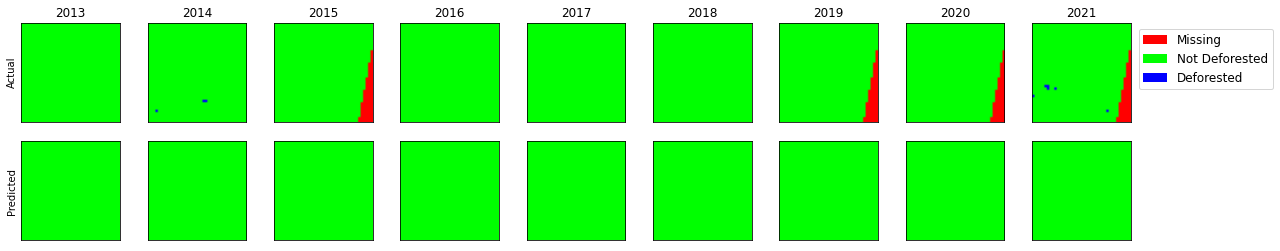

In [ ]:
# Visualize results

# Select a single, random raster from the test set
example = test_dataset[np.random.choice(range(len(test_dataset)), size=1)[0]]

# Split the frames into two parts
idx = example.shape[0] // 2
frames = example[:idx, ...]
original_frames = example[idx:, ...]

# Predict a new set of frames
for _ in range(idx):
    # Extract the model's prediction and post-process it.
    new_prediction_probs = model.predict(np.expand_dims(frames, axis=0))
    new_prediction_probs = np.squeeze(new_prediction_probs, axis=0)
    predicted_frame_probs = np.expand_dims(new_prediction_probs[-1, ...], axis=0)
    predicted_frame = np.eye(predicted_frame_probs.shape[3]) \
      [predicted_frame_probs.argmax(axis=3)] # convert probablities to 0s and 1s
    # Extend the set of prediction frames
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure to plot the original and predicted frames
fig, axes = plt.subplots(2, idx, figsize=(20, 4))

# Plot the original frames
for i, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[i]), cmap="gray")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(f"{2013 + i}")
    if i == (idx - 1):
        legend = [Patch(facecolor='red', label='Missing'),
                  Patch(facecolor='lime', label='Not Deforested'),
                  Patch(facecolor='blue', label='Deforested')]
        ax.legend(handles=legend, bbox_to_anchor=(2.5, 1), fontsize=12)
    if i==0:
        ax.set_ylabel("Actual")

# Plot the predicted frames
new_frames = frames[idx:, ...]
for i, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[i]), cmap="gray")
    ax.set_yticks([])
    ax.set_xticks([])
    if i==0:
        ax.set_ylabel("Predicted")

# Display the figure
plt.show()